In [87]:
#!pip install category-encoders
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

#from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [88]:
data_dir = Path("/content/dfFE11-v2.csv")
df = pd.read_csv(data_dir)
df

,city,status,numberRooms,numberBathrooms,numberBalconies,elevator,carParking,heating,houseSpace,PriceType_JOD,PriceType_NIS,PriceType_USD,featurePlus,Bldg_A,Bldg_B,Bldg_C,MedstatusHouseSpace,city_encoded,price
0,1,1,1,1,0,1,1,0,140.0,0,1,0,1.000000,0,0,0,140.0,2179.295502,1300
1,1,1,1,1,1,1,1,0,80.0,0,0,1,1.000000,1,0,0,140.0,2179.295502,550
2,1,1,3,3,2,1,1,1,190.0,0,0,1,1.000000,2,0,0,140.0,2179.295502,1000
3,1,1,3,3,1,1,1,1,190.0,0,0,1,1.000000,1,0,0,140.0,2179.295502,950
4,1,1,3,3,3,1,1,0,160.0,0,0,1,1.000000,3,0,0,140.0,2179.295502,800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,1,1,2,2,1,1,1,0,120.0,0,0,1,1.000000,1,0,0,140.0,1789.162426,600
7562,1,2,3,2,1,1,1,0,140.0,0,0,1,0.666667,0,1,0,140.0,1789.162426,500
7563,5,2,3,2,2,0,0,0,150.0,0,1,0,0.666667,0,2,0,140.0,4696.623612,1600
7564,4,1,1,1,1,1,1,1,70.0,0,1,0,1.000000,1,0,0,140.0,3882.401112,1000


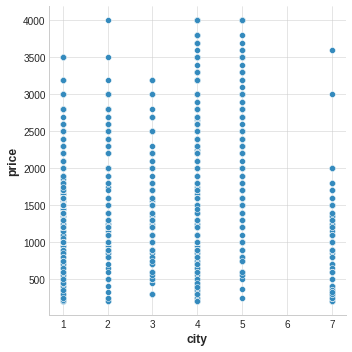

In [89]:
sns.relplot(x="city", y="price", data=df)

In [90]:
X = df.drop("price", axis=1)
X = X.drop("MedstatusHouseSpace", axis=1)
Y = df["price"].copy()
X

,city,status,numberRooms,numberBathrooms,numberBalconies,elevator,carParking,heating,houseSpace,PriceType_JOD,PriceType_NIS,PriceType_USD,featurePlus,Bldg_A,Bldg_B,Bldg_C,city_encoded
0,1,1,1,1,0,1,1,0,140.0,0,1,0,1.000000,0,0,0,2179.295502
1,1,1,1,1,1,1,1,0,80.0,0,0,1,1.000000,1,0,0,2179.295502
2,1,1,3,3,2,1,1,1,190.0,0,0,1,1.000000,2,0,0,2179.295502
3,1,1,3,3,1,1,1,1,190.0,0,0,1,1.000000,1,0,0,2179.295502
4,1,1,3,3,3,1,1,0,160.0,0,0,1,1.000000,3,0,0,2179.295502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,1,1,2,2,1,1,1,0,120.0,0,0,1,1.000000,1,0,0,1789.162426
7562,1,2,3,2,1,1,1,0,140.0,0,0,1,0.666667,0,1,0,1789.162426
7563,5,2,3,2,2,0,0,0,150.0,0,1,0,0.666667,0,2,0,4696.623612
7564,4,1,1,1,1,1,1,1,70.0,0,1,0,1.000000,1,0,0,3882.401112


In [91]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = .05, random_state= 42)

In [92]:
from sklearn.tree import DecisionTreeRegressor
#fit decision tree
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
#fit random forest
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(x_train, y_train)
#fit regression
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [93]:
models= [('lin_reg', lin_reg), ('random forest', forest), ('decision tree', tree)]
from sklearn.metrics import mean_squared_error
for i, model in models:    
    predictions = model.predict(x_train)
    MSE = mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of lin_reg = 450.89
RMSE of random forest = 160.38
RMSE of decision tree = 111.79


In [94]:
for i, model in models:
    # Make predictions on train data
    predictions = model.predict(x_train)
    # Performance metrics
    errors = abs(predictions - y_train)
    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(100 * (errors / y_train))
    # Calculate and display accuracy
    accuracy = 100 - mape    
    #print result
    msg = "%s= %.2f"% (i, round(accuracy, 2))
    print('Accuracy of', msg,'%')

Accuracy of lin_reg= 59.73 %
Accuracy of random forest= 88.19 %
Accuracy of decision tree= 94.13 %


In [95]:
from sklearn.model_selection import cross_validate
models= [('lin_reg', lin_reg), ('forest', forest), ('dt', tree)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']


results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, x_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

In [96]:
#THIS IS FOR Linear regression
#RMSE
LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()
# I changed the sign, as the result is originally a negative number for ease of computation
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()

#THIS IS FOR RF
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

#THIS IS FOR DT
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()

In [97]:
modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression', 'Random Forest', 'Decision Trees'],
    'RMSE_mean'    : [LR_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std, RF_RMSE_std, DT_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean, RF_MAE_mean, DT_MAE_mean],
    'MAE_std'   : [LR_MAE_std, RF_MAE_std, DT_MAE_std],
    'r2_mean'      : [LR_r2_mean, RF_r2_mean, DT_r2_mean],
    'r2_std'      : [LR_r2_std, RF_r2_std, DT_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
1,Random Forest,346.801765,13033.208192,191.639899,7.944748,0.765897,0.025794
2,Decision Trees,453.389128,27379.696922,222.806609,13.622359,0.611836,0.056828
0,Linear Regression,452.457160,20999.472725,280.702287,13.890589,0.599385,0.032068


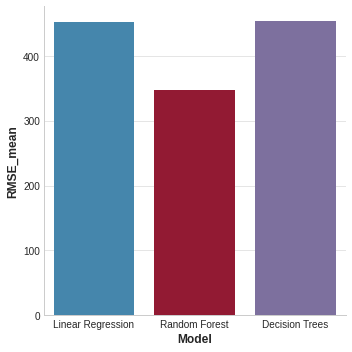

In [98]:
sns.factorplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend='True')

In [99]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_forest.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [100]:
#now let's how the RMSE changes for each parameter configuration
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

354.66273134998164 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
344.875688284748 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 25}
350.00225404591026 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 10}
348.2569393380057 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 25}
354.1115061294712 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 10}
344.00852150590214 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 25}
357.8212624300169 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 10}
343.6449226699986 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 25}
354.0398424502533 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 10}
343.77139904763965 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 25}
354.42907279226716 {'bootstrap': True, 'max_depth

In [101]:
#find the best model of grid search
grid_search_forest.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [102]:
grid_best= grid_search_forest.best_estimator_.predict(x_train)
errors = abs(grid_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_train))
accuracy = 100 - mape    
#print result
print('The best model from grid-search has an accuracy of', round(accuracy, 2),'%')

The best model from grid-search has an accuracy of 88.1 %


In [103]:
#RMSE
grid_mse = mean_squared_error(y_train, grid_best)
grid_rmse = np.sqrt(grid_mse)
print('The best model from the grid search has a RMSE of', round(grid_rmse, 2))

The best model from the grid search has a RMSE of 165.13


In [104]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [1, 23, 45],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 65, 110, 155, 200]}


In [105]:

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.7s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                  

In [106]:
#now let's how the RMSE changes for each parameter configuration
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

555.7527436276469 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 1}
555.7760068013688 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 1}
343.87514872815467 {'n_estimators': 65, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 23}
347.2283700948945 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
570.9530674741832 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
338.534345606422 {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 45}
339.0917386786354 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 23}
345.6329447840632 {'n_estimators': 155, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
570.8304444641101 {'n_estimators': 110, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
343.50122892465856 {'n_estimators': 110, 'min_samples_split

In [107]:
# best random model 
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=45, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [108]:
# best combination of parameters of random search
rf_random.best_params_

{'max_depth': 45,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 200}

In [109]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=45, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [110]:
# Performance metrics (MAPE)
random_best= rf_random.best_estimator_.predict(x_train)
errors = abs(random_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_train))
accuracy = 100 - mape    
#print result
print('The best model from the randomized search has an accuracy of', round(accuracy, 2),'%')

The best model from the randomized search has an accuracy of 83.7 %


In [111]:
#this is the RMSE
final_mse = mean_squared_error(y_train, random_best)
final_rmse = np.sqrt(final_mse)
print('The best model from the randomized search has a RMSE of', round(final_rmse, 2))

The best model from the randomized search has a RMSE of 217.7


In [112]:
# extract the numerical values of feature importance from the grid search
importances = rf_random.best_estimator_.feature_importances_

#create a feature list from the original dataset (list of columns)
feature_list = list(X.columns)

#create a list of tuples
feature_importance= sorted(zip(importances, feature_list), reverse=True)

#create two lists from the previous list of tuples
df2 = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df2['importance'])
feature= list(df2['feature'])

print(df2)

    importance          feature
0     0.197380    PriceType_USD
1     0.160902     city_encoded
2     0.126270             city
3     0.119763    PriceType_JOD
4     0.106031    PriceType_NIS
5     0.071002       houseSpace
6     0.035008  numberBathrooms
7     0.031765      numberRooms
8     0.027496           status
9     0.027255      featurePlus
10    0.019318         elevator
11    0.016677           Bldg_A
12    0.015163  numberBalconies
13    0.013836       carParking
14    0.012820          heating
15    0.011025           Bldg_B
16    0.008289           Bldg_C


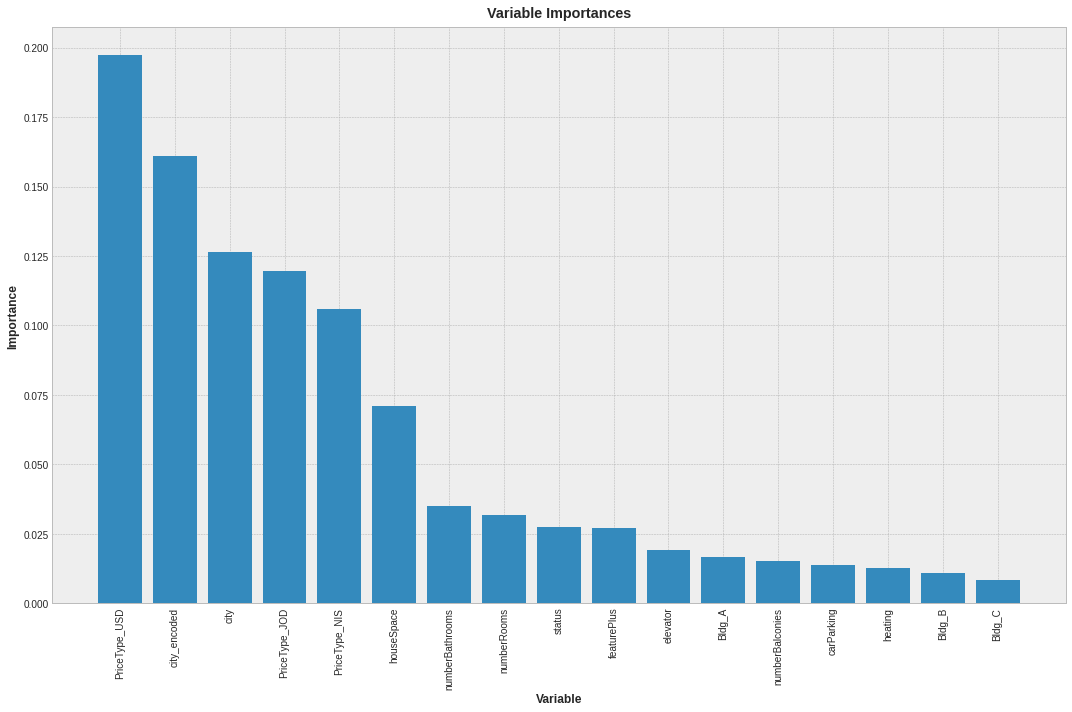

In [113]:
# Set the style
plt.style.use('bmh')
# list of x locations for plotting
x_values = list(range(len(feature_importance)))

# Make a bar chart
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
plt.xticks(x_values, feature, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [114]:
final_model = rf_random.best_estimator_
# Predicting test set results
final_pred = final_model.predict(x_test)
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
print('The final RMSE on the test set is', round(final_rmse, 2))

The final RMSE on the test set is 333.63


In [115]:

errors = abs(final_pred - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model achieves on the test set an accuracy of', round(accuracy, 2),'%')

The best model achieves on the test set an accuracy of 74.63 %


In [116]:
from joblib import dump,load
#dump(rf_random,'priceprediction.joblib')

In [117]:
index_names = x_test[ x_test['PriceType_NIS'] == 0  ].index 
index_names
# drop these row indexes 
# from dataFrame 
x_test.drop(index_names, inplace = True)
y_test.drop(index_names, inplace = True)

final_pred = final_model.predict(x_test)

errors = abs(final_pred - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model achieves on the test set an accuracy of', round(accuracy, 2),'%')

The best model achieves on the test set an accuracy of 68.21 %
